# Progetto CV: A.A 2020-2021

## Candidato: Scuderi Ivan, 216635

## Notebook di Training

### Import preliminari

In [1]:
SEED = 9246

import os
import math
import json
import time
from datetime import datetime
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models

from PIL import Image

from skimage import io
import pandas as pd
import numpy as np
import cv2
np.random.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support


import torchsummary
from libsvm import svmutil
from brisque import BRISQUE

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('Run on cuda!')

Run on cuda!


### Funzioni di utilità

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def image_quality_score(path_to_img):
    #funzione che calcola l'image quality score di una immagine
    #utilizzando la misura BRISQUE (Blind/Referenceless Image Spatial Quality Evaluator)
    #restituisce valori compresi tra 0 e 160 e maggiore è lo score e peggiore sarà la
    #qualità dell'immagine, si impiegherà tale metodo per il preprocessing
    brisq = BRISQUE()
    score = brisq.get_score(path_to_img)
    return score

def test(model, topk=10):
    print('Start testing the model ( topk = ',topk,')')
    predictions = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for x, y in testDataLoader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            _, idx = y_pred.topk(topk, dim=1)
            y_pred = torch.zeros_like(y_pred)
            
            y_pred.scatter_(1, idx, 1)
            predictions.append(y_pred.cpu())

            y_true.append(y.cpu())
    y_true, predictions = torch.cat(y_true, axis=0), torch.cat(predictions, axis=0)
    pr,re,f1,_ =precision_recall_fscore_support(y_true, predictions, average='micro')
    print("Test END: -- m_precision = ",np.round(pr,2), " -- m_recall = ",np.round(re,2)," -- m_f1 = ",np.round(f1,2))

### Preprocessing dei dati

Effettuo preprocessing andando ad eliminare tutti i frame che hanno BRISQUE (Blind/Referenceless Image Spatial Quality Evaluator) score superiore a 95:

In [3]:
DATASET_DIR = r'D:\1997i\Desktop\Magistrale\esami\secondo anno\secondo semestre\Analisi di Immagini e Video\progetto\progetto_2021_dataset_preproc\progetto_2021_dataset_labeled'
DRIVE_FOLDER = r'D:\1997i\Documenti\-- Notebook Analisi Immagini e Video\progetto\final\model_checkpoint'

In [4]:
# NON RUNNARE NUOVAMENTE PREPROCESSING ESEGUITO #

trailer_zero_frame = 0
frame_eliminati = 0
possibili_titoli_coda = []
trailer_zero = []
soglia = 95

for folder in os.listdir(DATASET_DIR):
    if folder == 'train_test_split_dict.json':
        continue
    path_folder = os.path.join(DATASET_DIR, folder)
    for img in os.listdir(path_folder):
        path_img = os.path.join(path_folder, img)
        prova = cv2.imread(path_img, 0)
        if prova is None:
            continue
        score = image_quality_score(path_img)
        if score > soglia:
            if score >= 110:
                possibili_titoli_coda.append(os.path.join(folder,img))
            os.remove(path_img)
            frame_eliminati += 1      
    if len(os.listdir(path_folder)) == 0:
        trailer_zero_frame += 1
        trailer_zero.append(folder)
            
print("Numero di frame eliminati: ", frame_eliminati)
print("Numero di trailer con 0 frame restanti: ", trailer_zero_frame)

Numero di frame eliminati:  2930
Numero di trailer con 0 frame restanti:  0


Esempio di frame che rappresentano possibili titoli di coda/pubblicità etc. :

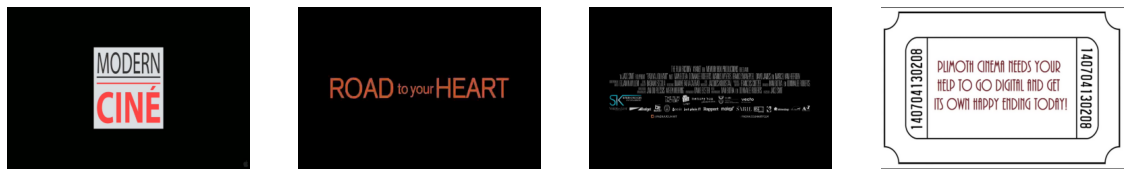

In [5]:
# NON RUNNARE NUOVAMENTE PREPROCESSING ESEGUITO #

DATASET_SHOW = r'D:\1997i\Desktop\Magistrale\esami\secondo anno\secondo semestre\Analisi di Immagini e Video\progetto\progetto_2021_dataset\progetto_2021_dataset_labeled'
possibili_titoli_coda = possibili_titoli_coda[:4]

fig, ax = plt.subplots(1, 4, figsize=(20,20))
for i in range(len(possibili_titoli_coda)):
    ax[i].imshow(cv2.imread(os.path.join(DATASET_SHOW,possibili_titoli_coda[i]))[:,:,[2,1,0]])
    ax[i].axis('off')
plt.show()

In [6]:
JSON_DATA = os.path.join(DATASET_DIR, 'train_test_split_dict.json')

with open(JSON_DATA) as fp:
    dataset_json = json.load(fp)

labels = set()

for k in dataset_json.values():
    for lable_list in k.values():
        for v in lable_list:
            labels.add(v)
            
label_idx = {v: i for i, v in enumerate(sorted(labels))}

print('Numero di etichette del dataset labeled: ', len(label_idx))

Numero di etichette del dataset labeled:  85


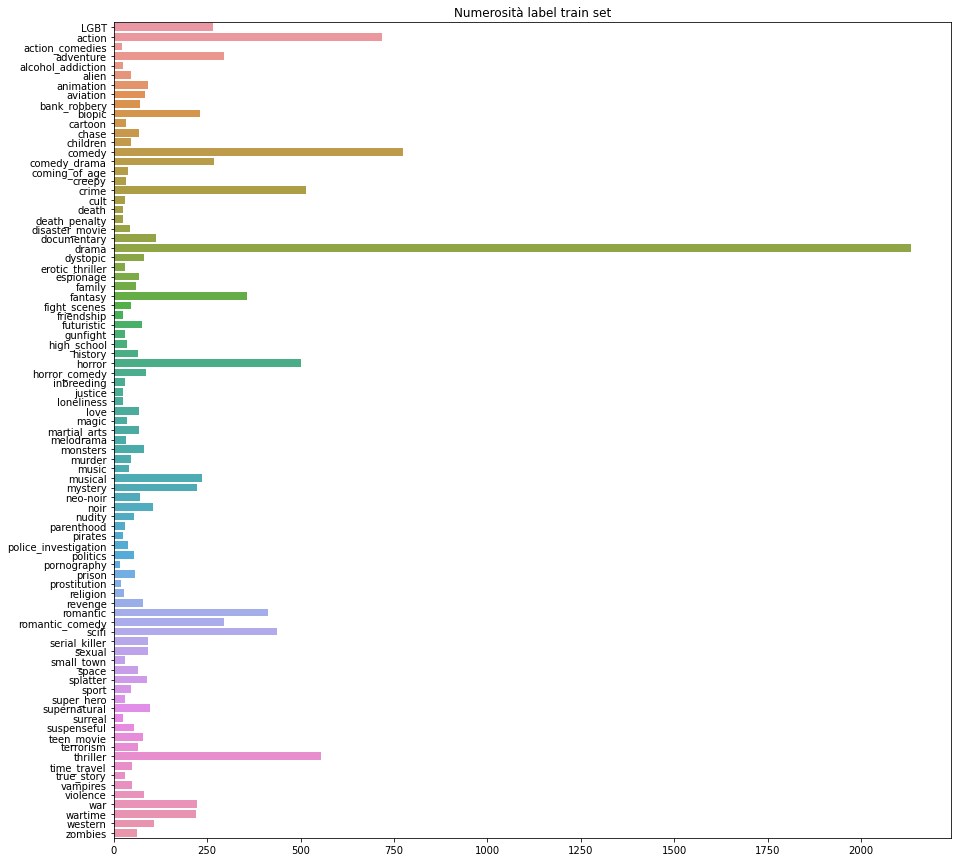

In [7]:
count = [0 for elem in label_idx]
for key in dataset_json['train']:
    for label in dataset_json['train'][key]:
        idx = label_idx[label]
        count[idx] += 1
count_label = {}
i = 0
for elem in list(label_idx.keys()):
    count_label[elem] = count[i]
    i += 1
count_label

df = pd.DataFrame.from_dict(count_label, orient='index')

plt.figure(figsize=(15,15))
plt.title("Numerosità label train set")
sns.barplot(x = df[0].values, y = df.index, orient = 'h')
plt.show()

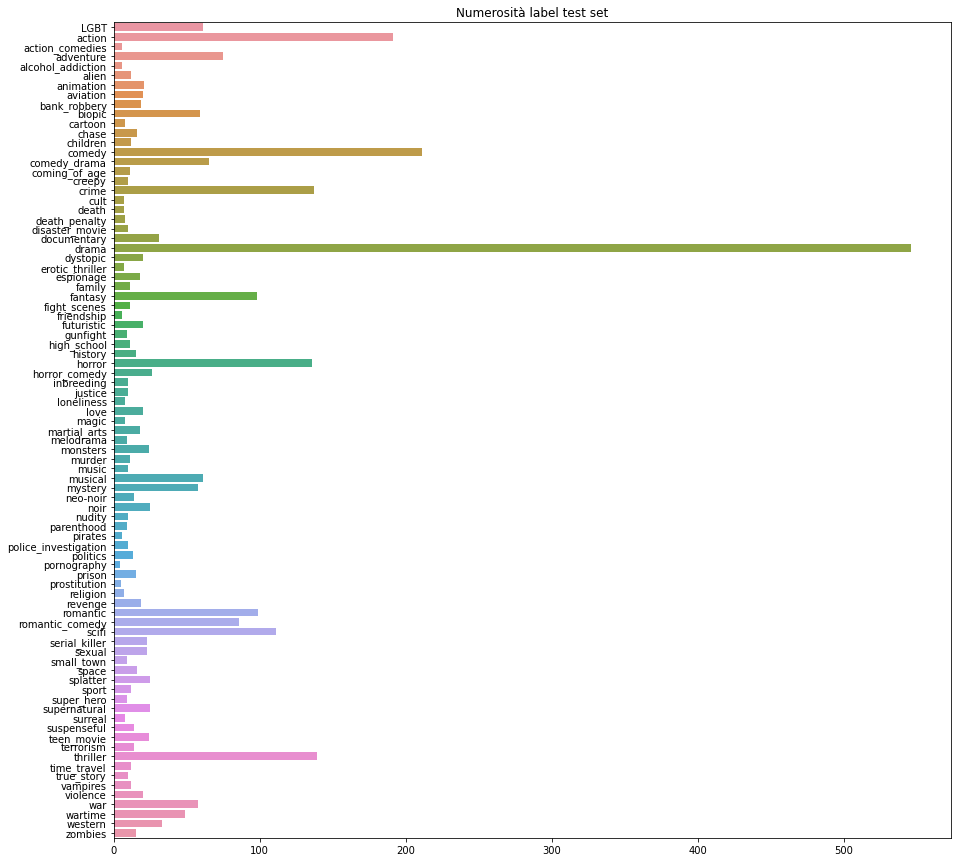

In [8]:
count_test = [0 for elem in label_idx]
for key in dataset_json['test']:
    for label in dataset_json['test'][key]:
        idx = label_idx[label]
        count_test[idx] += 1
count_label_test = {}
i = 0
for elem in list(label_idx.keys()):
    count_label_test[elem] = count_test[i]
    i += 1


df = pd.DataFrame.from_dict(count_label_test, orient='index')

plt.figure(figsize=(15,15))
plt.title("Numerosità label test set")
sns.barplot(x = df[0].values, y = df.index, orient = 'h')
plt.show()

Il dataset è fortemente sbilanciato, si può infatti vedere come i trailer con associati etichetta 'drama' sono molto più numerosi rispetto agli altri. Inoltre si può anche notare come questo sbilanciamento presente nei dati è pressocchè il medesimo anche all'interno del test set. Per mitigare ciò si vanno ad escludere i trailer che hanno come unica etichetta appunto 'drama':

In [9]:
train_dict = dataset_json['train']
trailer_esclusi = 0

for k in list(train_dict.keys()):
    labels = train_dict[k]
    if len(labels)==1 and labels[0] == 'drama':
        train_dict.pop(k)
        trailer_esclusi += 1

print("Numero di trailer con la sola etichetta 'drama' esclusi: ", trailer_esclusi)

Numero di trailer con la sola etichetta 'drama' esclusi:  378


In [10]:
restanti = int(df.loc['drama']) - trailer_esclusi
print("Numero di trailer etichetta 'drama' restanti: ", restanti)

Numero di trailer etichetta 'drama' restanti:  168


Siccome ancora tale etichetta risulta essere preponderante, si vanno a rimuovere tale etichetta dai primi N trailer che la contengono.

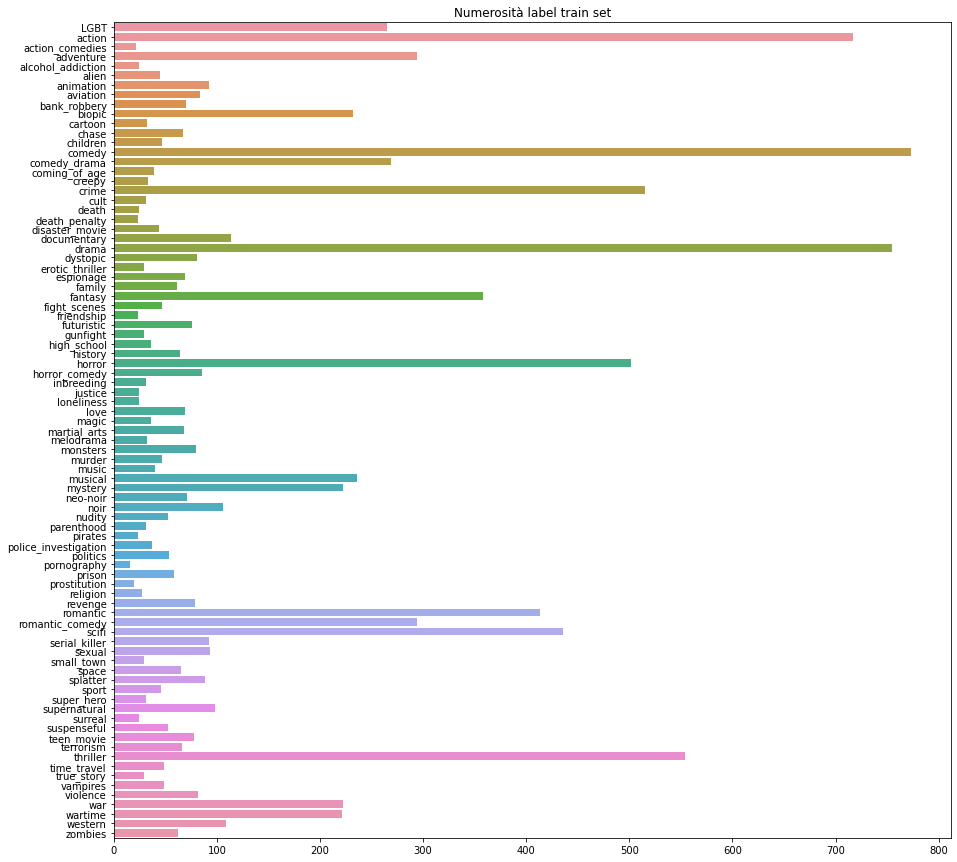

In [11]:
N = 1000
for k in list(train_dict.keys()):
    if N == 0:
        break
    labels = train_dict[k]
    if 'drama' in labels:
        labels.remove('drama')
        N -= 1
    
count = [0 for elem in label_idx]
for key in dataset_json['train']:
    for label in dataset_json['train'][key]:
        idx = label_idx[label]
        count[idx] += 1
count_label = {}
i = 0
for elem in list(label_idx.keys()):
    count_label[elem] = count[i]
    i += 1
count_label

df = pd.DataFrame.from_dict(count_label, orient='index')

plt.figure(figsize=(15,15))
plt.title("Numerosità label train set")
sns.barplot(x = df[0].values, y = df.index, orient = 'h')
plt.show()

Andiamo inoltre ad analizzare mediamente di quante label sono composti i vari trailer.

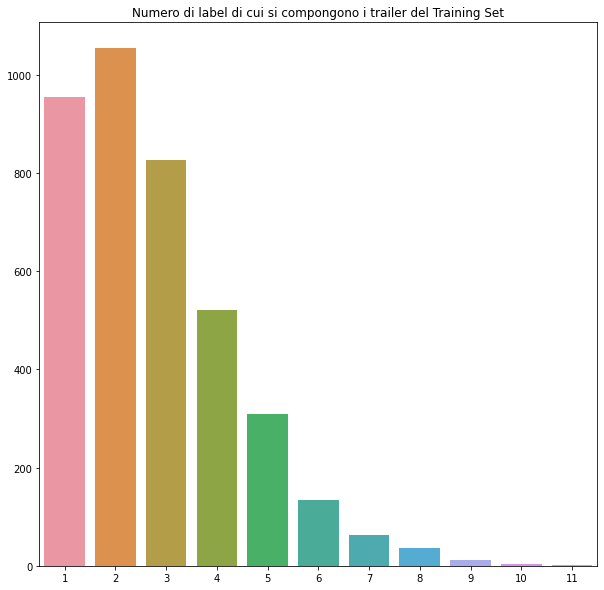

Numero di label medie di cui si compongono i trailer del training set (calcolate con media pesate):  2.77


In [12]:
n_label = {}

for k in dataset_json['train'].keys():
    labels = dataset_json['train'][k]
    if len(labels) in n_label:
        n_label[len(labels)] += 1
    else:
        n_label[len(labels)] = 1

df = pd.DataFrame.from_dict(n_label, orient='index')

plt.figure(figsize=(10,10))
plt.title("Numero di label di cui si compongono i trailer del Training Set")
sns.barplot(x = df.index, y = df[0].values)
plt.show()

l = df.index.to_numpy()
w = df[0].to_numpy()

media = np.round(np.average(l, weights=w),2)
print("Numero di label medie di cui si compongono i trailer del training set (calcolate con media pesate): ",media)

Andiamo ora ad analizzare il numero di frame di cui si compongono mediamente i trailer del training set:

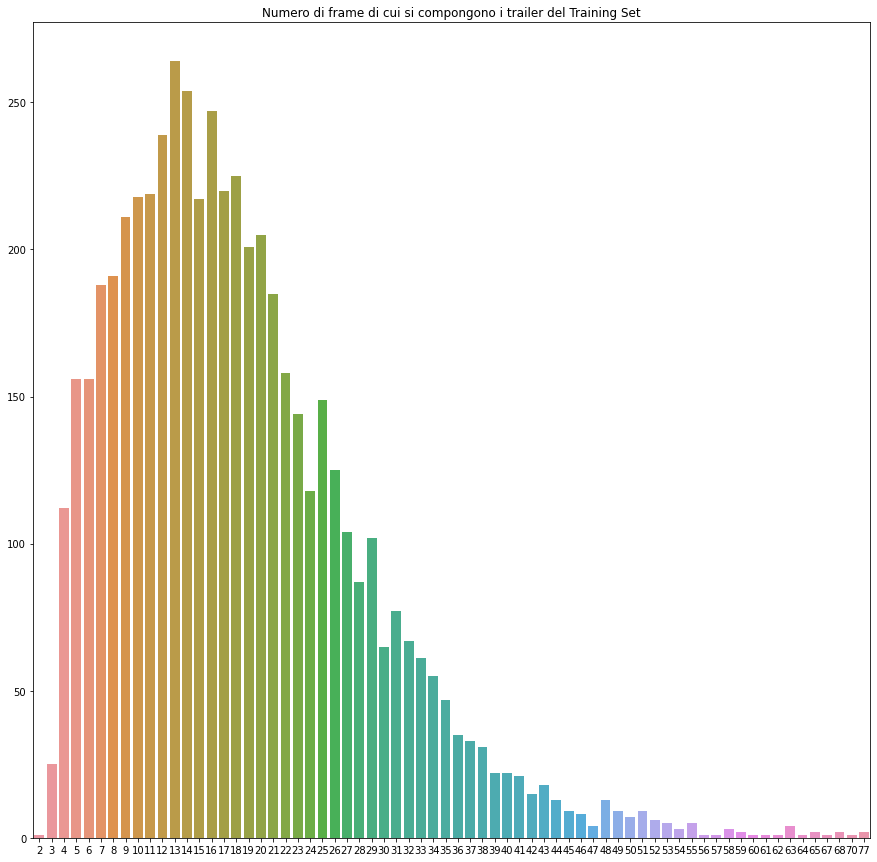

Numero di frame medi di cui si compongono i trailer del training set (calcolato con media pesate):  18.24


In [13]:
n_frame = {}

for folder in os.listdir(DATASET_DIR):
    if folder == 'train_test_split_dict.json':
        continue
    list_folder = os.listdir(os.path.join(DATASET_DIR, folder))
    if len(list_folder) in n_frame:
        n_frame[len(list_folder)] += 1
    else:
        n_frame[len(list_folder)] = 1

df = pd.DataFrame.from_dict(n_frame, orient='index')

plt.figure(figsize=(15,15))
plt.title("Numero di frame di cui si compongono i trailer del Training Set")
sns.barplot(x = df.index, y = df[0].values)
plt.show()

l = df.index.to_numpy()
w = df[0].to_numpy()

media = np.round(np.average(l, weights=w),2)
print("Numero di frame medi di cui si compongono i trailer del training set (calcolato con media pesate): ",media)

### Dataset & DataLoader

Per via di alcuni problemi riguardanti il sistema operativo Windows e Jupyter, non mi è stato possibile utilizzare la classe VideoDataset se dichiarata in una cella del notebook. Da qui la scelta di andarla ad implementare in un apposito file di utilità.

In [14]:
from utils_proc_shuffle import VideoDataset

limit = 20

datasetTrain = VideoDataset(DATASET_DIR, dataset_json['train'], label_idx, limit, train=True, shuffle=True)
datasetTest = VideoDataset(DATASET_DIR, dataset_json['test'], label_idx, limit, train=False, shuffle=False)

print('Dimensione Dataset (train, test) : ',len(datasetTrain), len(datasetTest))

Dimensione Dataset (train, test) :  3914 1112


In [15]:
batch_size = 16
trainingDataLoader = torch.utils.data.DataLoader(datasetTrain, 
                                                 batch_size=batch_size, 
                                                 shuffle=True, 
                                                 num_workers=2)

testDataLoader = torch.utils.data.DataLoader(datasetTest, 
                                             batch_size=batch_size, 
                                             shuffle=True, 
                                             num_workers=2)

print('Numero di batch complessivi (trainLabeled, testLabeled): ',len(trainingDataLoader), len(testDataLoader))

Numero di batch complessivi (trainLabeled, testLabeled):  245 70


### Generazione Modello

Definisco alcuni metodi che mi serviranno per il salvataggio/caricamento del modello/checkpoint.

In [16]:
CHECKPOINT = os.path.join(DRIVE_FOLDER, 'model.checkpoint')
MODELFILE = os.path.join(DRIVE_FOLDER, 'model.pth')

def save_checkpoint(epoch, model, optimizer, loss):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, CHECKPOINT)

def load_checkpoint(model, optimizer):
    if not os.path.exists(CHECKPOINT):
        return None, None
    checkpoint = torch.load(CHECKPOINT)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return epoch, loss

def save_model(model):
    torch.save(model.state_dict(), MODELFILE)
    print('Salvataggio modello avvenuto con successo!')

def load_model(model):
    if os.path.exists(MODELFILE):
        model.load_state_dict(torch.load(MODELFILE))
        print("Caricamento modello avvenuto con successo!")

In [17]:
net = models.vgg19(pretrained = True)

for params in net.parameters():
  params.requires_grad = False

print('Numero parametri backbone: ',count_parameters(net))

net

Numero parametri backbone:  0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [18]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

net.fc2 = Identity()

In [19]:
fully_connected = nn.Sequential(
    nn.Conv1d(20,20,kernel_size=(3),padding=1,stride=2),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Conv1d(20,32,kernel_size=(3),padding=1,stride=2),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),
    nn.Conv1d(32,64,kernel_size=(3),padding=1,stride=2),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Conv1d(64,64,kernel_size=(3),padding=1,stride=2),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),
    nn.Flatten(),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512,85),
    nn.Sigmoid()
)

print('Numero parametri fully connected layers: ',count_parameters(fully_connected))

fully_connected

Numero parametri fully connected layers:  590497


Sequential(
  (0): Conv1d(20, 20, kernel_size=(3,), stride=(2,), padding=(1,))
  (1): ReLU()
  (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv1d(20, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (4): ReLU()
  (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU()
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (12): ReLU()
  (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.5, inplace=False)
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Linear(in_features=1024

Vado a definire i pesi che userà la loss in modo tale da dare maggiore importanza agli errori commessi sulle classi poco numerose:

In [20]:
weight = [1/math.sqrt(elem) for elem in count]

for i in range(len(weight)):
    if weight[i] == 1:
        weight[i] = 0

weight = torch.FloatTensor(weight)
weight = weight.to(device)

weight

tensor([0.0614, 0.0373, 0.2132, 0.0583, 0.2000, 0.1491, 0.1043, 0.1091, 0.1195,
        0.0657, 0.1768, 0.1222, 0.1459, 0.0360, 0.0610, 0.1601, 0.1741, 0.0441,
        0.1796, 0.2000, 0.2041, 0.1508, 0.0937, 0.0364, 0.1111, 0.1857, 0.1204,
        0.1280, 0.0529, 0.1459, 0.2041, 0.1147, 0.1857, 0.1667, 0.1250, 0.0446,
        0.1078, 0.1796, 0.2000, 0.2000, 0.1204, 0.1667, 0.1213, 0.1768, 0.1118,
        0.1459, 0.1581, 0.0651, 0.0671, 0.1187, 0.0971, 0.1374, 0.1796, 0.2041,
        0.1644, 0.1361, 0.2500, 0.1313, 0.2236, 0.1925, 0.1125, 0.0492, 0.0583,
        0.0479, 0.1043, 0.1037, 0.1857, 0.1240, 0.1060, 0.1474, 0.1796, 0.1010,
        0.2000, 0.1374, 0.1132, 0.1231, 0.0425, 0.1429, 0.1857, 0.1429, 0.1104,
        0.0671, 0.0673, 0.0958, 0.1270], device='cuda:0')

In [21]:
class MyNet(nn.Module):
    def __init__(self,backbone,fully_connected):
      super().__init__()
      self.backbone = backbone
      self.fully_connected = fully_connected

    def forward(self,x):
        vector = torch.zeros((x.size(0),limit,1000))
        i = 0
        for trailer in x:
            output = self.backbone(trailer) 
            vector[i] = output
            i +=1
        result = self.fully_connected(vector.to(device))
        return result

In [22]:
model = MyNet(net,fully_connected)
model = model.to(device)

print('Numero parametri model: ',count_parameters(model))

model

Numero parametri model:  590497


MyNet(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [23]:
lr = 1e-3
#weight_decay = 1e-2
criterion = nn.BCELoss(weight=weight)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
epoca = 0

In [24]:
load_model(model)

Caricamento modello avvenuto con successo!


In [20]:
# MIGLIOR RISULTATO DOPO 30 EPOCHE #

epoca, error = load_checkpoint(model,optimizer)

epochs = 36
train_losses = []
test_losses = []
last_epoch = epoca

print_every = 20

try:
    for epoch in range(last_epoch or 0, epochs):
        print('Start epoch', epoch+1)
        model.train()
        running_loss = 0
        steps = 0
        for x, y in trainingDataLoader:

            steps += 1

            if epoch == 0 and steps == 1:
                print(f'input shape is {x.shape}, labels are {y.shape}')

            #x = x.view(16,20,3,224,224)
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logit = model(x)

            loss = criterion(logit, y)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()
            
            if steps % print_every == 0:
                print(f"epoch {epoch+1}/{epochs} "
                      f"train loss: {running_loss/steps:.6f} ")

                save_checkpoint(epoch, model, optimizer, loss)

        train_losses.append(running_loss/steps)
        print(f"END Epoch {epoch+1}/{epochs} "
              f"Train loss: {running_loss/steps:.6f} ")
        save_model(model)
        if (epoch+1)%2 == 0:
            # effettuo il test ogni due epoche
            test_losses.append(test(model))
except KeyboardInterrupt: 
    print('Exiting from training early')

save_model(model)

Start epoch 30
epoch 30/36 train loss: 0.009790 
epoch 30/36 train loss: 0.010042 
epoch 30/36 train loss: 0.009915 
epoch 30/36 train loss: 0.009918 
epoch 30/36 train loss: 0.009818 
epoch 30/36 train loss: 0.009673 
epoch 30/36 train loss: 0.009674 
epoch 30/36 train loss: 0.009858 
epoch 30/36 train loss: 0.009877 
epoch 30/36 train loss: 0.009912 
epoch 30/36 train loss: 0.010017 
epoch 30/36 train loss: 0.010084 
END Epoch 30/36 Train loss: 0.010135 
Salvataggio modello avvenuto con successo!
Start testing the model
Test END loss: 0.116695 
Start epoch 31
epoch 31/36 train loss: 0.010284 
epoch 31/36 train loss: 0.010061 
epoch 31/36 train loss: 0.010148 
epoch 31/36 train loss: 0.010440 
epoch 31/36 train loss: 0.010343 
epoch 31/36 train loss: 0.010278 
epoch 31/36 train loss: 0.010162 
epoch 31/36 train loss: 0.010197 
epoch 31/36 train loss: 0.010214 
epoch 31/36 train loss: 0.010225 
epoch 31/36 train loss: 0.010236 
epoch 31/36 train loss: 0.010235 
END Epoch 31/36 Train lo

Vado ad effettuare il plot dell'errore durante la fase di training:

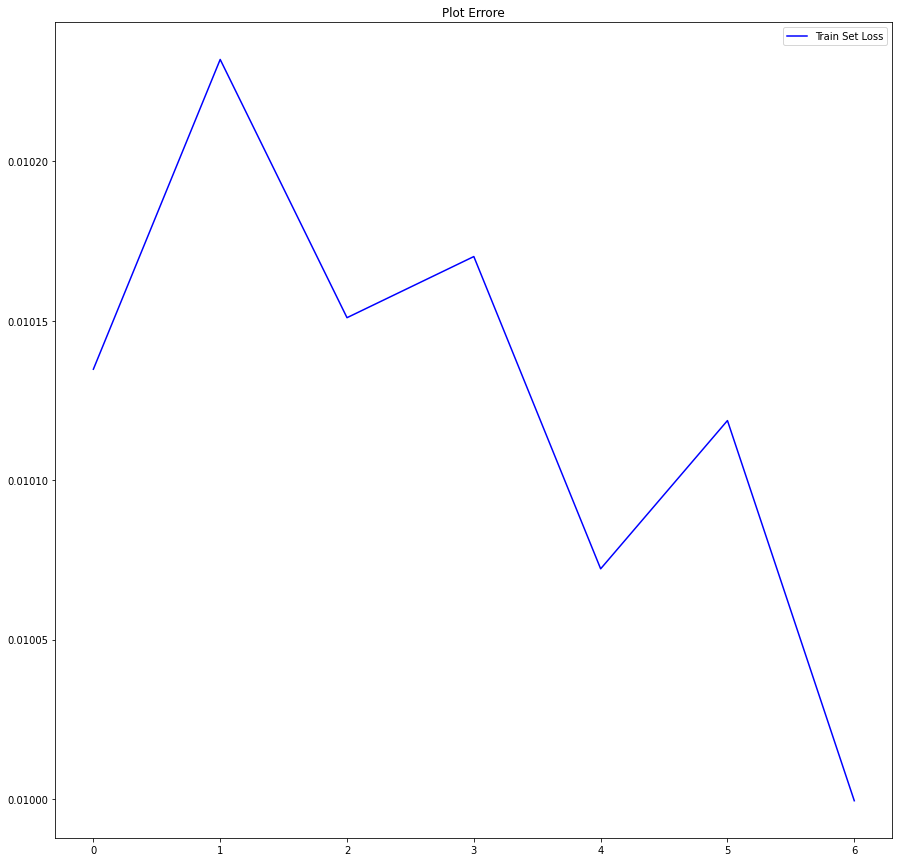

In [21]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(np.array(train_losses),'b', label='Train Set Loss')
ax.legend(loc='best')
ax.set_title('Plot Errore')
plt.show()

### Testing del modello ottenuto

In [25]:
test(model, topk=10)
print()
test(model, topk=7)
print()
test(model, topk=5)

Start testing the model ( topk =  10 )
Test END: -- m_precision =  0.17  -- m_recall =  0.6  -- m_f1 =  0.27

Start testing the model ( topk =  7 )
Test END: -- m_precision =  0.21  -- m_recall =  0.52  -- m_f1 =  0.3

Start testing the model ( topk =  5 )
Test END: -- m_precision =  0.25  -- m_recall =  0.43  -- m_f1 =  0.31


In [26]:
topk=10
predictions = []
y_true = []

model.eval()

with torch.no_grad():
    for inputs, labels in testDataLoader:
        inputs = inputs.to(device)

        y_pred = model(inputs)

        _, idx = y_pred.topk(topk, dim=1)

        y_pred = torch.zeros_like(y_pred)
        y_pred.scatter_(1, idx, 1)
        predictions.append(y_pred.cpu())

        y_true.append(labels.cpu())


y_true, predictions = torch.cat(y_true, axis=0), torch.cat(predictions, axis=0)
report = classification_report(y_true, predictions, 
                               target_names=list(sorted(label_idx.keys())),zero_division=0)
print(report)

                      precision    recall  f1-score   support

                LGBT       0.08      0.72      0.14        61
              action       0.22      0.94      0.36       191
     action_comedies       0.00      0.00      0.00         6
           adventure       0.13      0.76      0.22        75
   alcohol_addiction       0.00      0.00      0.00         6
               alien       0.00      0.00      0.00        12
           animation       0.23      0.86      0.36        21
            aviation       0.00      0.00      0.00        20
        bank_robbery       0.00      0.00      0.00        19
              biopic       0.09      0.32      0.14        59
             cartoon       0.10      0.50      0.17         8
               chase       0.29      0.12      0.17        16
            children       0.13      0.25      0.17        12
              comedy       0.19      0.99      0.32       211
        comedy_drama       0.07      0.77      0.13        65
       

Dopo 30 epoche: micro avg f1-score 0.27 con 41 classi con f1-score > 0